# Multivariate forecasting
> Tutorial on how to do multivariate forecasting using TSMixer models.

In _multivariate_ forecasting, we use the information from every time series to produce all forecasts for all time series jointly. In contrast, in _univariate_ forecasting we only consider the information from every individual time series and produce forecasts for every time series separately. Multivariate forecasting methods thus use more information to produce every forecast, and thus should be able to provide better forecasting results. However, multivariate forecasting methods also scale with the number of time series, which means these methods are commonly less well suited for large-scale problems (i.e. forecasting many, many time series).

In this notebook, we will demonstrate the performance of a state-of-the-art multivariate forecasting architecture `TSMixer` when compared to a univariate forecasting method (`NHITS`).

We will show how to:
* Load the [ETTm2](https://github.com/zhouhaoyi/ETDataset) benchmark dataset, used in the academic literature.
* Train a TSMixer model
* Forecast the test set
* Optimize the hyperparameters

You can run these experiments using GPU with Google Colab.

<a href="https://colab.research.google.com/github/Nixtla/neuralforecast/blob/main/nbs/examples/LongHorizon_with_Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Installing libraries

In [ ]:
%%capture
!pip install neuralforecast datasetsforecast

## 2. Load ETTm2 Data

The `LongHorizon` class will automatically download the complete ETTm2 dataset and process it.

It return three Dataframes: `Y_df` contains the values for the target variables, `X_df` contains exogenous calendar features and `S_df` contains static features for each time-series (none for ETTm2). For this example we will only use `Y_df`.

If you want to use your own data just replace `Y_df`. Be sure to use a long format and have a simmilar structure than our data set.

In [1]:
import pandas as pd

from datasetsforecast.long_horizon import LongHorizon

In [2]:
# Change this to your own data to try the model
Y_df, _, _ = LongHorizon.load(directory='./', group='ETTm2')
Y_df['ds'] = pd.to_datetime(Y_df['ds'])

n_time = len(Y_df.ds.unique())
val_size = int(.2 * n_time)
test_size = int(.2 * n_time)

## 3. Train models

We will train models using the `cross_validation` method, which allows users to automatically simulate multiple historic forecasts (in the test set).

The `cross_validation` method will use the validation set for hyperparameter selection and early stopping, and will then produce the forecasts for the test set.

First, instantiate each model in the `models` list, specifying the `horizon`, `input_size`, and training iterations.

In [47]:
%%capture
from neuralforecast.core import NeuralForecast
from neuralforecast.models import TSMixer, NHITS
from neuralforecast.losses.pytorch import MSE, MAE

In [73]:
%%capture
horizon = 720
input_size = 512
models = [
          TSMixer(h=horizon,
                input_size=input_size,
                n_series=7,
                max_steps=1000,
                val_check_steps=100,
                early_stop_patience_steps=5,
                valid_loss=MAE(),
                random_seed=12345678,
                ),           
           NHITS(h=horizon,
                input_size=horizon,
                max_steps=1000,
                val_check_steps=100,
                early_stop_patience_steps=5,
                scaler_type='robust',
                valid_loss=MAE(),
                ),                                                                       
         ]

INFO:lightning_fabric.utilities.seed:Seed set to 12345678
INFO:lightning_fabric.utilities.seed:Seed set to 1


:::{.callout-tip}
Check our `auto` models for automatic hyperparameter optimization.
:::

Instantiate a `NeuralForecast` object with the following required parameters:

* `models`: a list of models.

* `freq`: a string indicating the frequency of the data. (See [panda's available frequencies](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases).)

Second, use the `cross_validation` method, specifying the dataset (`Y_df`), validation size and test size.

In [74]:
%%capture
nf = NeuralForecast(
    models=models,
    freq='15min')

Y_hat_df = nf.cross_validation(df=Y_df,
                               val_size=val_size,
                               test_size=test_size,
                               n_windows=None)                                 
Y_hat_df = Y_hat_df.reset_index()                               

The `cross_validation` method will return the forecasts for each model on the test set.

## 4. Evaluate Results

Next, we plot the forecasts on the test set for the `OT` variable for all models.

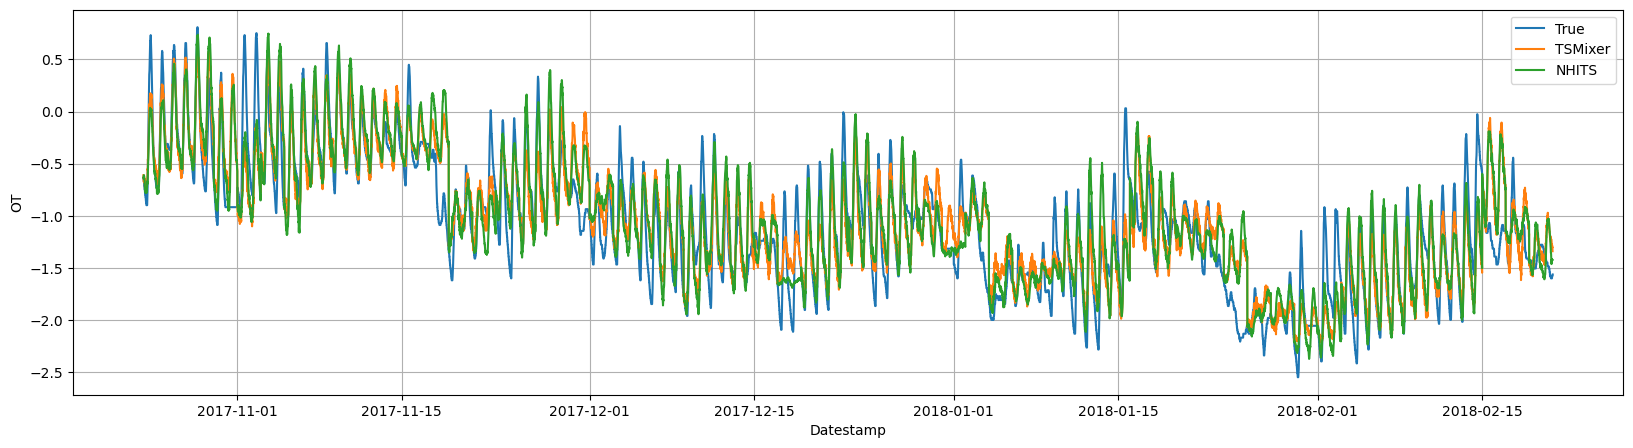

In [68]:
import matplotlib.pyplot as plt
Y_plot = Y_hat_df[Y_hat_df['unique_id']=='OT'] # OT dataset
cutoffs = Y_hat_df['cutoff'].unique()[::horizon]
Y_plot = Y_plot[Y_hat_df['cutoff'].isin(cutoffs)]

plt.figure(figsize=(20,5))
plt.plot(Y_plot['ds'], Y_plot['y'], label='True')
plt.plot(Y_plot['ds'], Y_plot['TSMixer'], label='TSMixer')
plt.plot(Y_plot['ds'], Y_plot['NHITS'], label='NHITS')
plt.xlabel('Datestamp')
plt.ylabel('OT')
plt.grid()
plt.legend()

Finally, we compute the test errors using the Mean Absolute Error (MAE) and Mean Squared Error (MSE):

$\qquad MAE = \frac{1}{Windows * Horizon} \sum_{\tau} |y_{\tau} - \hat{y}_{\tau}| \qquad$ and $\qquad MSE = \frac{1}{Windows * Horizon} \sum_{\tau} (y_{\tau} - \hat{y}_{\tau})^{2} \qquad$

In [75]:
from neuralforecast.losses.numpy import mse, mae

mae_tsmixer = mae(Y_hat_df['y'], Y_hat_df['TSMixer'])
mse_tsmixer = mse(Y_hat_df['y'], Y_hat_df['TSMixer'])
mae_nhits = mae(Y_hat_df['y'], Y_hat_df['NHITS'])
mse_nhits = mse(Y_hat_df['y'], Y_hat_df['NHITS'])

print(f'TSMixer horizon {horizon} - MAE: {mae_tsmixer:.3f}')
print(f'TSMixer horizon {horizon} - MSE: {mse_tsmixer:.3f}')
print(f'NHITS horizon {horizon} - MAE: {mae_nhits:.3f}')
print(f'NHITS horizon {horizon} - MSE: {mse_nhits:.3f}')

TSMixer horizon 720 - MAE: 0.382
TSMixer horizon 720 - MSE: 0.363
NHITS horizon 720 - MAE: 0.420
NHITS horizon 720 - MSE: 0.445


For reference, we can check the performance when compared to self-reported performance in the paper. We find that `TSMixer` provides better results than the _univariate_ method `NHITS`. Also, our implementation of `TSMixer` very closely tracks the results of the original paper.

Mean Absolute Error (MAE)

| Horizon   |TSMixer<br> (this notebook) | TSMixer <br>(paper)  | NHITS <br>(this notebook)    | NHITS <br>(paper) 
|---        |---        |---        |---        |---       
|  96       | **0.249** | 0.252     |  0.251    |   0.255      
|  192      | **0.289** | 0.290     |  0.294    |   0.305      
|  336      | 0.325     | **0.324** |  0.345    |   0.346      
|  720      | **0.382** | 0.422     |  0.420    |   0.413     

Mean Squared Error (MSE)

| Horizon   |TSMixer<br> (this notebook) | TSMixer <br>(paper)  | NHITS <br>(this notebook)    | NHITS <br>(paper) 
|---        |---        |---            |---                |---            
|  96       | **0.163** | **0.163**     |  0.178            |   0.176      
|  192      | 0.221     | **0.216**     |  0.243            |   0.245       
|  336      | 0.275     | **0.268**     |  0.315            |   0.295       
|  720      | 0.363     | 0.420         |  0.445            |   0.401      

Note that for the table above, we use the same hyperparameters for both methods for all horizons, whereas the original papers tune the hyperparameters for each horizon.

## 5. Tuning the hyperparameters
The `AutoTSMixer` class will automatically perform hyperparamter tunning using the [Tune library](https://docs.ray.io/en/latest/tune/index.html), exploring a user-defined or default search space. Models are selected based on the error on a validation set and the best model is then stored and used during inference. 

The `AutoTSMixer.default_config` attribute contains a suggested hyperparameter space. Here, we specify a different search space following the paper's hyperparameters. Feel free to play around with this space.

In [27]:
from ray import tune
from ray.tune.search.hyperopt import HyperOptSearch
from neuralforecast.auto import AutoTSMixer

horizon = 96 # 24hrs = 4 * 15 min.

tsmixer_config = {
       "input_size": input_size,                                                 # Size of input window
       "max_steps": tune.choice([500, 1000, 2000]),                              # Number of training iterations
       "val_check_steps": 100,                                                   # Compute validation every x steps
       "early_stop_patience_steps": 5,                                           # Early stopping steps
       "learning_rate": tune.loguniform(1e-4, 1e-2),                             # Initial Learning rate
       "n_block": tune.choice([1, 2, 4, 6, 8]),                                  # Number of mixing layers
       "dropout": tune.uniform(0.0, 0.99),                                       # Dropout
       "ff_dim": tune.choice([32, 64, 128]),                                     # Dimension of the feature linear layer
       "scaler_type": 'identity',       
    }

To instantiate `AutoTSMixer` you need to define:

* `h`: forecasting horizon
* `n_series`: number of time series in the multivariate time series problem.

In addition, we define the following parameters (if these are not given, the `AutoTSMixer` class will use a pre-defined value):
* `loss`: training loss. Use the `DistributionLoss` to produce probabilistic forecasts.
* `config`: hyperparameter search space. If `None`, the `AutoTSMixer` class will use a pre-defined suggested hyperparameter space.
* `num_samples`: number of configurations explored. For this example, we only use a limited amount of `10`.
* `search_alg`: type of search algorithm used for selecting parameter values within the hyperparameter space.
* `backend`: the backend used for the hyperparameter optimization search, either `ray` or `optuna`. 
* `valid_loss`: the loss used for the validation sets in the optimization procedure.

In [33]:
model = AutoTSMixer(h=horizon,
                    n_series=7,
                    loss=MAE(),
                    config=tsmixer_config,
                    num_samples=10,
                    search_alg=HyperOptSearch(),
                    backend='ray',
                    valid_loss=MAE())

Now, we fit the model by instantiating a `NeuralForecast` object with the following required parameters:

* `models`: a list of models.

* `freq`: a string indicating the frequency of the data. (See [panda's available frequencies](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases).)

The `cross_validation` method allows you to simulate multiple historic forecasts, greatly simplifying pipelines by replacing for loops with `fit` and `predict` methods.

With time series data, cross validation is done by defining a sliding window across the historical data and predicting the period following it. This form of cross validation allows us to arrive at a better estimation of our model’s predictive abilities across a wider range of temporal instances while also keeping the data in the training set contiguous as is required by our models.

The `cross_validation` method will use the validation set for hyperparameter selection, and will then produce the forecasts for the test set.

In [38]:
%%capture
nf = NeuralForecast(models=[model], freq='15min')
Y_hat_df = nf.cross_validation(df=Y_df, val_size=val_size,
                               test_size=test_size, n_windows=None)

2024-03-04 11:25:17,476	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949
2024-03-04 11:25:34,632	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
2024-03-04 11:25:49,218	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
2024-03-04 11:25:57,228	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
2024-03-04 11:26:10,213	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de89

## 6. Evaluate Results

The `AutoTSMixer` class contains a `results` attribute that stores information of each configuration explored. It contains the validation loss and best validation hyperparameter. The result dataframe `Y_hat_df` that we obtained in the previous step is based on the best config of the hyperparameter search.

In [39]:
nf.models[0].results.get_best_result().config

{'input_size': 512,
 'max_steps': 1000,
 'val_check_steps': 100,
 'early_stop_patience_steps': 5,
 'learning_rate': 0.0006856130644189468,
 'n_block': 2,
 'dropout': 0.8647150628018399,
 'ff_dim': 64,
 'scaler_type': 'identity',
 'n_series': 7,
 'h': 96,
 'loss': MAE(),
 'valid_loss': MAE()}

We compute the test errors of the best config for the two metrics of interest:

$\qquad MAE = \frac{1}{Windows * Horizon} \sum_{\tau} |y_{\tau} - \hat{y}_{\tau}| \qquad$ and $\qquad MSE = \frac{1}{Windows * Horizon} \sum_{\tau} (y_{\tau} - \hat{y}_{\tau})^{2} \qquad$

In [42]:
y_true = Y_hat_df.y.values
y_hat = Y_hat_df['AutoTSMixer'].values

print(f'MAE: {mae(y_hat, y_true):.3f}')
print(f'MSE: {mse(y_hat, y_true):.3f}')

MAE: 0.248
MSE: 0.162


We can compare the error metrics for our optimized setting to the earlier setting in which we used the default hyperparameters. In this case, for a horizon of 96, we got slightly improved results on both metrics as compared to the default settings, demonstrating the benefit of hyperparameter optimization. 

| Metric    |TSMixer<br> (optimized) | TSMixer <br>(default)  | TSMixer <br>(paper)   
|---        |---                     |---                     |---
| MAE       |**0.248**               | 0.249                  | 0.252     
| MSE       |**0.162**               | 0.163                  | 0.163     

Note that we only evaluated 10 hyperparameter configurations (`num_samples=10`), which may suggest that it is possible to further improve forecasting performance by exploring more hyperparameter configurations.

## References

[Chen, Si-An, Chun-Liang Li, Nate Yoder, Sercan O. Arik, and Tomas Pfister (2023). "TSMixer: An All-MLP Architecture for Time Series Forecasting."](http://arxiv.org/abs/2303.06053)
[Cristian Challu, Kin G. Olivares, Boris N. Oreshkin, Federico Garza, Max Mergenthaler-Canseco, Artur Dubrawski (2021). NHITS: Neural Hierarchical Interpolation for Time Series Forecasting. Accepted at AAAI 2023.](https://arxiv.org/abs/2201.12886)